# Northwind Database Project

Northwind Co. Sales Analysis <br>
Name: Hazel Donaldson <br>
Due Date: 8/26/2019 <br>

# Project Overview:

For this project, I will be exploring data provided by my client, Northwind, containing company wide sales data on a range of projects. The goal is to derive a significance of discounts on overall sales as well as additional business recommendations based on the results of EDA.

## Obtain Data/Import Libraries

In [1]:
#import libraries here
import sqlite3
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from collections import Counter
import itertools


In [76]:
#define functions

#population mean
def calculate_mu(x):
    mu = float(sum(x.values)/len(x))
    return mu
# Create tables from database
def get_column_info(table):
    cols_list = inspector.get_columns(table)
    print('')
    print('-----------------------------------------------------------------------')
    print(f'Table Name: {table}, Primary Key: {inspector.get_primary_keys(table)}')
    print('------------------------------------------------------------------------')
    print('')
    for column in cols_list:
         print(f"Column Name: {column['name']}, Column Type: {column['type']}")

#Cohen's d
def cohen_d(group1, group2):
               
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return abs(d)

In [73]:
#alternative
engine = create_engine('sqlite:///Northwind_small.sqlite', echo = True)
Session = sessionmaker(bind=engine)
session = Session()

In [4]:
from sqlalchemy import inspect
inspector = inspect(engine)

print(inspector.get_table_names())

2019-08-16 14:18:19,177 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-08-16 14:18:19,183 INFO sqlalchemy.engine.base.Engine ()
2019-08-16 14:18:19,186 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-08-16 14:18:19,190 INFO sqlalchemy.engine.base.Engine ()
2019-08-16 14:18:19,194 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-08-16 14:18:19,196 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


In [5]:
tables = inspector.get_table_names()
for table in tables:
    print(get_column_info(table))

2019-08-16 14:18:19,213 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Category")
2019-08-16 14:18:19,215 INFO sqlalchemy.engine.base.Engine ()

-----------------------------------------------------------------------
2019-08-16 14:18:19,230 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'Category' AND type = 'table'
2019-08-16 14:18:19,234 INFO sqlalchemy.engine.base.Engine ()
Table Name: Category, Primary Key: ['Id']
------------------------------------------------------------------------

Column Name: Id, Column Type: INTEGER
Column Name: CategoryName, Column Type: VARCHAR(8000)
Column Name: Description, Column Type: VARCHAR(8000)
None
2019-08-16 14:18:19,240 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Customer")
2019-08-16 14:18:19,242 INFO sqlalchemy.engine.base.Engine ()

-----------------------------------------------------------------------
2019-08-16 14:18:19,247 INFO s

Table Name: Product, Primary Key: ['Id']
------------------------------------------------------------------------

Column Name: Id, Column Type: INTEGER
Column Name: ProductName, Column Type: VARCHAR(8000)
Column Name: SupplierId, Column Type: INTEGER
Column Name: CategoryId, Column Type: INTEGER
Column Name: QuantityPerUnit, Column Type: VARCHAR(8000)
Column Name: UnitPrice, Column Type: DECIMAL
Column Name: UnitsInStock, Column Type: INTEGER
Column Name: UnitsOnOrder, Column Type: INTEGER
Column Name: ReorderLevel, Column Type: INTEGER
Column Name: Discontinued, Column Type: INTEGER
None
2019-08-16 14:18:19,393 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Region")
2019-08-16 14:18:19,395 INFO sqlalchemy.engine.base.Engine ()

-----------------------------------------------------------------------
2019-08-16 14:18:19,399 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'Region' AND type

C:\Users\Hazel\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SADeprecationWarning: The Inspector.get_primary_keys() method is deprecated and will be removed in a future release.  Please refer to the Inspector.get_pk_constraint() method.
  if sys.path[0] == '':


2019-08-16 14:18:19,413 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'Shipper' AND type = 'table'
2019-08-16 14:18:19,415 INFO sqlalchemy.engine.base.Engine ()
Table Name: Shipper, Primary Key: ['Id']
------------------------------------------------------------------------

Column Name: Id, Column Type: INTEGER
Column Name: CompanyName, Column Type: VARCHAR(8000)
Column Name: Phone, Column Type: VARCHAR(8000)
None
2019-08-16 14:18:19,420 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Supplier")
2019-08-16 14:18:19,421 INFO sqlalchemy.engine.base.Engine ()

-----------------------------------------------------------------------
2019-08-16 14:18:19,425 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'Supplier' AND type = 'table'
2019-08-16 14:18:19,426 INFO sqlalchemy.engine.base.Engine ()
Table N

In [ ]:
#connect to database
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

In [ ]:
#list of all tables
data = cur.execute("SELECT name FROM sqlite_master WHERE type = 'table';").fetchall()
data = [i[0] for i in data]

In [ ]:
#loop list of data into pandas dataframe
dfs = []
for i in tables:
    table = cur.execute('select * from "'+ i +'"').fetchall()
    columns = cur.execute('PRAGMA table_info("'+ i +'")').fetchall()
    #df = pd.DataFrame(table, columns = [i[1] for i in columns])
    foo = i +'_df'
    exec(foo + "=df")
    dfs.append(foo)

In [ ]:
dfs

In [6]:
#Converting the database tables into Pandas dataframes
df_Category = pd.read_sql_query("SELECT * FROM Category", engine)
df_Customer = pd.read_sql_query("SELECT * FROM Customer", engine)
df_CustomerDemographic = pd.read_sql_query("SELECT * FROM CustomerDemographic", engine)
df_Employee = pd.read_sql_query("SELECT * FROM Employee", engine)
df_EmployeeTerritory = pd.read_sql_query("SELECT * FROM EmployeeTerritory", engine)
df_order = pd.read_sql_query("SELECT * FROM 'Order'", engine)
df_Product = pd.read_sql_query("SELECT * FROM Product", engine)
df_region = pd.read_sql_query("SELECT * FROM Region", engine)
df_Supplier = pd.read_sql_query("SELECT * FROM Supplier", engine)
df_Territory = pd.read_sql_query("SELECT * FROM Territory", engine)
df_OrderDetail = pd.read_sql_query("SELECT * FROM OrderDetail", engine)
df_Shipper = pd.read_sql_query("SELECT * FROM Shipper", engine)
df_customercustomerdemo = pd.read_sql_query("SELECT * FROM CustomerCustomerDemo", engine)

2019-08-16 14:18:24,746 INFO sqlalchemy.engine.base.Engine SELECT * FROM Category
2019-08-16 14:18:24,748 INFO sqlalchemy.engine.base.Engine ()
2019-08-16 14:18:24,763 INFO sqlalchemy.engine.base.Engine SELECT * FROM Customer
2019-08-16 14:18:24,764 INFO sqlalchemy.engine.base.Engine ()
2019-08-16 14:18:24,774 INFO sqlalchemy.engine.base.Engine SELECT * FROM CustomerDemographic
2019-08-16 14:18:24,775 INFO sqlalchemy.engine.base.Engine ()
2019-08-16 14:18:24,782 INFO sqlalchemy.engine.base.Engine SELECT * FROM Employee
2019-08-16 14:18:24,784 INFO sqlalchemy.engine.base.Engine ()
2019-08-16 14:18:24,794 INFO sqlalchemy.engine.base.Engine SELECT * FROM EmployeeTerritory
2019-08-16 14:18:24,795 INFO sqlalchemy.engine.base.Engine ()
2019-08-16 14:18:24,802 INFO sqlalchemy.engine.base.Engine SELECT * FROM 'Order'
2019-08-16 14:18:24,803 INFO sqlalchemy.engine.base.Engine ()
2019-08-16 14:18:24,825 INFO sqlalchemy.engine.base.Engine SELECT * FROM Product
2019-08-16 14:18:24,826 INFO sqlalch

## Pre-process data

Now, I will familiarize myself with the contents of each table. For each table, I will preview the contents, check for null values, and make sure the data is in the proper format for hypothesis testing.

### Category Table:

In [7]:
df_Category.head()

,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"


In [8]:
print(df_Category.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
Id              8 non-null int64
CategoryName    8 non-null object
Description     8 non-null object
dtypes: int64(1), object(2)
memory usage: 272.0+ bytes
None


In [9]:
df_Category.groupby(['CategoryName']).head(10)

,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"
5,6,Meat/Poultry,Prepared meats
6,7,Produce,Dried fruit and bean curd
7,8,Seafood,Seaweed and fish


Based on this exploration, it looks like Nortwind is a food and beverage distribution. I may explore which categrory is doing the best in terms of sales. Now, we should get a better picture of the the products sold by Northwind.

## Product Table

In [10]:
df_Product.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


In [11]:
print(df_Product.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 10 columns):
Id                 77 non-null int64
ProductName        77 non-null object
SupplierId         77 non-null int64
CategoryId         77 non-null int64
QuantityPerUnit    77 non-null object
UnitPrice          77 non-null float64
UnitsInStock       77 non-null int64
UnitsOnOrder       77 non-null int64
ReorderLevel       77 non-null int64
Discontinued       77 non-null int64
dtypes: float64(1), int64(7), object(2)
memory usage: 6.1+ KB
None


In [12]:
#Identifying the types of products sold by Northwind
df_Product.ProductName.unique()

array(['Chai', 'Chang', 'Aniseed Syrup', "Chef Anton's Cajun Seasoning",
       "Chef Anton's Gumbo Mix", "Grandma's Boysenberry Spread",
       "Uncle Bob's Organic Dried Pears", 'Northwoods Cranberry Sauce',
       'Mishi Kobe Niku', 'Ikura', 'Queso Cabrales',
       'Queso Manchego La Pastora', 'Konbu', 'Tofu', 'Genen Shouyu',
       'Pavlova', 'Alice Mutton', 'Carnarvon Tigers',
       'Teatime Chocolate Biscuits', "Sir Rodney's Marmalade",
       "Sir Rodney's Scones", "Gustaf's Knäckebröd", 'Tunnbröd',
       'Guaraná Fantástica', 'NuNuCa Nuß-Nougat-Creme',
       'Gumbär Gummibärchen', 'Schoggi Schokolade', 'Rössle Sauerkraut',
       'Thüringer Rostbratwurst', 'Nord-Ost Matjeshering',
       'Gorgonzola Telino', 'Mascarpone Fabioli', 'Geitost',
       'Sasquatch Ale', 'Steeleye Stout', 'Inlagd Sill', 'Gravad lax',
       'Côte de Blaye', 'Chartreuse verte', 'Boston Crab Meat',
       "Jack's New England Clam Chowder", 'Singaporean Hokkien Fried Mee',
       'Ipoh Coffee', 'Gula

In [13]:
# Finding the products that are discontinued
df_Product.Discontinued.value_counts()

0    69
1     8
Name: Discontinued, dtype: int64

As we can see above, Northwind distributed 77 products, some of which are discontinued. For now, I will ignore the presence of the discontinued products but include them in the analysis. If it is found that those products have a positive effect on sales, I will recommend that those products be restocked.

## Customer Table

In [14]:
df_Customer.head()

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67


In [15]:
print(df_Customer.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 11 columns):
Id              91 non-null object
CompanyName     91 non-null object
ContactName     91 non-null object
ContactTitle    91 non-null object
Address         91 non-null object
City            91 non-null object
Region          91 non-null object
PostalCode      90 non-null object
Country         91 non-null object
Phone           91 non-null object
Fax             69 non-null object
dtypes: object(11)
memory usage: 7.9+ KB
None


In [16]:
#Indentifying the names of Northwind's customers:
df_Customer.CompanyName.unique()

array(['Alfreds Futterkiste', 'Ana Trujillo Emparedados y helados',
       'Antonio Moreno Taquería', 'Around the Horn', 'Berglunds snabbköp',
       'Blauer See Delikatessen', 'Blondesddsl père et fils',
       'Bólido Comidas preparadas', 'Bon app', 'Bottom-Dollar Markets',
       "B's Beverages", 'Cactus Comidas para llevar',
       'Centro comercial Moctezuma', 'Chop-suey Chinese',
       'Comércio Mineiro', 'Consolidated Holdings',
       'Drachenblut Delikatessen', 'Du monde entier',
       'Eastern Connection', 'Ernst Handel', 'Familia Arquibaldo',
       'FISSA Fabrica Inter. Salchichas S.A.', 'Folies gourmandes',
       'Folk och fä HB', 'Frankenversand', 'France restauration',
       'Franchi S.p.A.', 'Furia Bacalhau e Frutos do Mar',
       'Galería del gastrónomo', 'Godos Cocina Típica',
       'Gourmet Lanchonetes', 'Great Lakes Food Market',
       'GROSELLA-Restaurante', 'Hanari Carnes', 'HILARION-Abastos',
       'Hungry Coyote Import Store', 'Hungry Owl All-Night Groce

In [17]:
df_customer_demo = df_Customer.groupby(['Region'])['CompanyName'].count()
df_customer_demo

Region
British Isles       8
Central America     5
Eastern Europe      1
North America      16
Northern Europe     4
Scandinavia         3
South America      16
Southern Europe    10
Western Europe     28
Name: CompanyName, dtype: int64

In [18]:
df_customer_demo_country = df_Customer.groupby(['Country'])['CompanyName'].count()
print(len(df_customer_demo_country))
df_customer_demo_country


21


Country
Argentina       3
Austria         2
Belgium         2
Brazil          9
Canada          3
Denmark         2
Finland         2
France         11
Germany        11
Ireland         1
Italy           3
Mexico          5
Norway          1
Poland          1
Portugal        2
Spain           5
Sweden          2
Switzerland     2
UK              7
USA            13
Venezuela       4
Name: CompanyName, dtype: int64

Based on customer demographics, Northwind operates internationally with customers in 21 different countries. The USA, France, Germany and the UK being their biggest customers with 13, 11, 11, and 7 respectively. Regionally, Western Europe and North America are their biggest customers with 28 and 16 respectively. 

In [19]:
#dropping the Fax column:
df_Customer.drop(['Fax'], axis = 1, inplace = True)

In [20]:
#Filling null values in the Postal Code column:
df_Customer.PostalCode.fillna('0', inplace = True)

In [21]:
#Reviewing Customer Table:
df_Customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 10 columns):
Id              91 non-null object
CompanyName     91 non-null object
ContactName     91 non-null object
ContactTitle    91 non-null object
Address         91 non-null object
City            91 non-null object
Region          91 non-null object
PostalCode      91 non-null object
Country         91 non-null object
Phone           91 non-null object
dtypes: object(10)
memory usage: 7.2+ KB


In [22]:
df_Customer.ContactTitle.unique() #will employees of certain titles have more effect on sales?

array(['Sales Representative', 'Owner', 'Order Administrator',
       'Marketing Manager', 'Accounting Manager', 'Sales Agent',
       'Sales Associate', 'Sales Manager', 'Marketing Assistant',
       'Assistant Sales Agent', 'Assistant Sales Representative',
       'Owner/Marketing Assistant'], dtype=object)

## CustomerCustomer Demo Table:

In [ ]:
df_customercustomerdemo.info()

## Employee Table:

In [23]:
df_Employee.head()

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp
2,3,Leverling,Janet,Sales Representative,Ms.,1995-08-30,2024-04-01,722 Moss Bay Blvd.,Kirkland,North America,98033,USA,(206) 555-3412,3355,None,Janet has a BS degree in chemistry from Boston...,2.0,http://accweb/emmployees/leverling.bmp
3,4,Peacock,Margaret,Sales Representative,Mrs.,1969-09-19,2025-05-03,4110 Old Redmond Rd.,Redmond,North America,98052,USA,(206) 555-8122,5176,None,Margaret holds a BA in English literature from...,2.0,http://accweb/emmployees/peacock.bmp
4,5,Buchanan,Steven,Sales Manager,Mr.,1987-03-04,2025-10-17,14 Garrett Hill,London,British Isles,SW1 8JR,UK,(71) 555-4848,3453,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp


In [24]:
print(df_Employee.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 18 columns):
Id                 9 non-null int64
LastName           9 non-null object
FirstName          9 non-null object
Title              9 non-null object
TitleOfCourtesy    9 non-null object
BirthDate          9 non-null object
HireDate           9 non-null object
Address            9 non-null object
City               9 non-null object
Region             9 non-null object
PostalCode         9 non-null object
Country            9 non-null object
HomePhone          9 non-null object
Extension          9 non-null object
Photo              0 non-null object
Notes              9 non-null object
ReportsTo          8 non-null float64
PhotoPath          9 non-null object
dtypes: float64(1), int64(1), object(16)
memory usage: 1.3+ KB
None


In [25]:
df_employee_names = df_Employee.groupby(['FirstName', 'LastName'])['FirstName', 'LastName', 'Region', 'Country', 'City', 'HireDate']
df_employee_names.head(10)

,FirstName,LastName,Region,Country,City,HireDate
0,Nancy,Davolio,North America,USA,Seattle,2024-05-01
1,Andrew,Fuller,North America,USA,Tacoma,2024-08-14
2,Janet,Leverling,North America,USA,Kirkland,2024-04-01
3,Margaret,Peacock,North America,USA,Redmond,2025-05-03
4,Steven,Buchanan,British Isles,UK,London,2025-10-17
5,Michael,Suyama,British Isles,UK,London,2025-10-17
6,Robert,King,British Isles,UK,London,2026-01-02
7,Laura,Callahan,North America,USA,Seattle,2026-03-05
8,Anne,Dodsworth,British Isles,UK,London,2026-11-15


Northwind had a total of nine employees who work mainly in the USA and offices in Seattle and London areas. In our EDA, we may choose to compare sales between the Seattle and London offices.

In [26]:
#filling the missing value in the ReportsTo column:
df_Employee.ReportsTo.fillna(2.0, inplace = True)

In [27]:
df_Employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 18 columns):
Id                 9 non-null int64
LastName           9 non-null object
FirstName          9 non-null object
Title              9 non-null object
TitleOfCourtesy    9 non-null object
BirthDate          9 non-null object
HireDate           9 non-null object
Address            9 non-null object
City               9 non-null object
Region             9 non-null object
PostalCode         9 non-null object
Country            9 non-null object
HomePhone          9 non-null object
Extension          9 non-null object
Photo              0 non-null object
Notes              9 non-null object
ReportsTo          9 non-null float64
PhotoPath          9 non-null object
dtypes: float64(1), int64(1), object(16)
memory usage: 1.3+ KB


In [28]:
df_EmployeeTerritory.head()

,Id,EmployeeId,TerritoryId
0,1/06897,1,06897
1,1/19713,1,19713
2,2/01581,2,01581
3,2/01730,2,01730
4,2/01833,2,01833


In [29]:
df_EmployeeTerritory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 3 columns):
Id             49 non-null object
EmployeeId     49 non-null int64
TerritoryId    49 non-null object
dtypes: int64(1), object(2)
memory usage: 1.2+ KB


In [30]:
print(df_region.info())
df_region.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
Id                   4 non-null int64
RegionDescription    4 non-null object
dtypes: int64(1), object(1)
memory usage: 144.0+ bytes
None


,Id,RegionDescription
0,1,Eastern
1,2,Western
2,3,Northern
3,4,Southern


In [31]:
# Can we indentify employee territories? Where they make their sales?
df_employee_terr_pairs = pd.read_sql_query("""SELECT e.LastName, t.TerritoryDescription, r.RegionDescription \
            FROM [Employee] e \
            INNER JOIN [EmployeeTerritory] et on et.EmployeeId = e.Id \
            INNER JOIN [Territory] t on t.Id = et.TerritoryId \
            INNER JOIN [Region] r on r.Id = t.RegionId
            GROUP BY e.LastName
            ORDER BY r.RegionDescription ASC;""", engine)
df_employee_terr_pairs.head(10)

2019-08-16 14:19:17,955 INFO sqlalchemy.engine.base.Engine SELECT e.LastName, t.TerritoryDescription, r.RegionDescription             FROM [Employee] e             INNER JOIN [EmployeeTerritory] et on et.EmployeeId = e.Id             INNER JOIN [Territory] t on t.Id = et.TerritoryId             INNER JOIN [Region] r on r.Id = t.RegionId
            GROUP BY e.LastName
            ORDER BY r.RegionDescription ASC;
2019-08-16 14:19:17,957 INFO sqlalchemy.engine.base.Engine ()


,LastName,TerritoryDescription,RegionDescription
0,Buchanan,Providence,Eastern
1,Davolio,Wilton,Eastern
2,Fuller,Westboro,Eastern
3,Peacock,Rockville,Eastern
4,Callahan,Philadelphia,Northern
5,Dodsworth,Hollis,Northern
6,Leverling,Atlanta,Southern
7,King,Hoffman Estates,Western
8,Suyama,Phoenix,Western


Looks like most of Northwind's employees is assigned to the Eastern region. In our EDA, we may investigate if there are some high performing regions where Northwind could do future business.

## Order, Order Detail Table

In [32]:
df_order.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [33]:
print(df_order.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 14 columns):
Id                830 non-null int64
CustomerId        830 non-null object
EmployeeId        830 non-null int64
OrderDate         830 non-null object
RequiredDate      830 non-null object
ShippedDate       809 non-null object
ShipVia           830 non-null int64
Freight           830 non-null float64
ShipName          830 non-null object
ShipAddress       830 non-null object
ShipCity          830 non-null object
ShipRegion        830 non-null object
ShipPostalCode    811 non-null object
ShipCountry       830 non-null object
dtypes: float64(1), int64(3), object(10)
memory usage: 90.9+ KB
None


In [34]:
df_order.ShipRegion.unique()

array(['Western Europe', 'South America', 'Central America',
       'North America', 'Northern Europe', 'Scandinavia',
       'Southern Europe', 'British Isles', 'Eastern Europe'], dtype=object)

In [35]:
df_OrderDetail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [36]:
df_OrderDetail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [37]:

df_region_review = pd.read_sql_query("""SELECT o.ShipRegion, \
            SUM(od.Quantity * od.UnitPrice * (1-od.Discount)) TotalRev \
            FROM [OrderDetail] od \
            INNER JOIN [Order] o on o.Id = od.OrderId \
            GROUP BY o.ShipRegion \
            ORDER BY TotalRev DESC""", engine)
df_region_review.head(10)

2019-08-16 14:19:29,991 INFO sqlalchemy.engine.base.Engine SELECT o.ShipRegion,             SUM(od.Quantity * od.UnitPrice * (1-od.Discount)) TotalRev             FROM [OrderDetail] od             INNER JOIN [Order] o on o.Id = od.OrderId             GROUP BY o.ShipRegion             ORDER BY TotalRev DESC
2019-08-16 14:19:29,992 INFO sqlalchemy.engine.base.Engine ()


,ShipRegion,TotalRev
0,Western Europe,505164.3085
1,North America,295780.9005
2,South America,171855.5055
3,British Isles,108951.2150
4,Northern Europe,87156.1625
5,Southern Europe,45225.7175
6,Scandinavia,24545.2025
7,Central America,23582.0775
8,Eastern Europe,3531.9500


In [38]:
#dropping ShippingPostalCode column:
df_order.drop(['ShipPostalCode'], axis = 1, inplace = True)

In [39]:
#fill ShippedDate column:
df_order.ShippedDate.fillna('0', inplace = True)

## Shipper, Supplier table

In [40]:
df_Shipper.head()

,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


In [41]:
df_Shipper.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
Id             3 non-null int64
CompanyName    3 non-null object
Phone          3 non-null object
dtypes: int64(1), object(2)
memory usage: 152.0+ bytes


In [42]:
df_Supplier.head()

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,HomePage
0,1,Exotic Liquids,Charlotte Cooper,Purchasing Manager,49 Gilbert St.,London,British Isles,EC1 4SD,UK,(171) 555-2222,None,None
1,2,New Orleans Cajun Delights,Shelley Burke,Order Administrator,P.O. Box 78934,New Orleans,North America,70117,USA,(100) 555-4822,None,#CAJUN.HTM#
2,3,Grandma Kelly's Homestead,Regina Murphy,Sales Representative,707 Oxford Rd.,Ann Arbor,North America,48104,USA,(313) 555-5735,(313) 555-3349,None
3,4,Tokyo Traders,Yoshi Nagase,Marketing Manager,9-8 Sekimai Musashino-shi,Tokyo,Eastern Asia,100,Japan,(03) 3555-5011,None,None
4,5,Cooperativa de Quesos 'Las Cabras',Antonio del Valle Saavedra,Export Administrator,Calle del Rosal 4,Oviedo,Southern Europe,33007,Spain,(98) 598 76 54,None,None


In [43]:
print(df_Supplier.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 12 columns):
Id              29 non-null int64
CompanyName     29 non-null object
ContactName     29 non-null object
ContactTitle    29 non-null object
Address         29 non-null object
City            29 non-null object
Region          29 non-null object
PostalCode      29 non-null object
Country         29 non-null object
Phone           29 non-null object
Fax             13 non-null object
HomePage        5 non-null object
dtypes: int64(1), object(11)
memory usage: 2.8+ KB
None


# Exploratory Data Analysis

## 1) Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

#### 1a) Do discounts have a statistically significant effect on the number of products customers order?

$H_0$: Discounts have no effect on the number of products customers order <br>
$H_a$: Discounts have an effect on the number of products customers order <br>
$alpha$ : 0.05

First, we need to visually check if discounts really does make a difference in order quantity.

In [44]:
# need to separate discounts from no discounts, make a new dataframe for it
df_discount_find = pd.read_sql_query("""SELECT ProductId, UnitPrice, Quantity, Discount FROM 
                                OrderDetail""", engine)
df_discount_find.head()

2019-08-16 14:19:45,099 INFO sqlalchemy.engine.base.Engine SELECT ProductId, UnitPrice, Quantity, Discount FROM 
                                OrderDetail
2019-08-16 14:19:45,100 INFO sqlalchemy.engine.base.Engine ()


,ProductId,UnitPrice,Quantity,Discount
0,11,14.0,12,0.0
1,42,9.8,10,0.0
2,72,34.8,5,0.0
3,14,18.6,9,0.0
4,51,42.4,40,0.0


In [47]:
#new column to indentify if there is a discount or not
df_discount_find['DisBool'] = df_discount_find.Discount.apply(lambda x : 0 if x == 0  else 1)
df_discount_find.head(10)

,ProductId,UnitPrice,Quantity,Discount,DisBool
0,11,14.0,12,0.00,0
1,42,9.8,10,0.00,0
2,72,34.8,5,0.00,0
3,14,18.6,9,0.00,0
4,51,42.4,40,0.00,0
5,41,7.7,10,0.00,0
6,51,42.4,35,0.15,1
7,65,16.8,15,0.15,1
8,22,16.8,6,0.05,1
9,57,15.6,15,0.05,1


In [48]:
# getting feel for the types of discounts
df_discount_find.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

Above we can see there are some small discounts of 1% to 4%, which are possibly problematic for our conclusion. Also the quanties customers ordered for those discounts are so small, it looks like it made a negative impact. These discounts will be removed from the analysis.

In [49]:
#create a new dataframe for discounts larger than 0.04?
df_discount_find = df_discount_find[df_discount_find.Discount.isin(['0.00', '0.05', '0.10', '0.15', '0.20', '0.25'])]
df_discount_find.describe()

,ProductId,UnitPrice,Quantity,Discount,DisBool
count,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000
mean,40.805776,26.203987,23.895203,0.056265,0.386586
std,22.148297,29.855453,19.009580,0.083586,0.487081
min,1.000000,2.000000,1.000000,0.000000,0.000000
25%,22.000000,12.000000,10.000000,0.000000,0.000000
50%,41.000000,18.400000,20.000000,0.000000,0.000000
75%,60.000000,32.000000,30.000000,0.100000,1.000000
max,77.000000,263.500000,130.000000,0.250000,1.000000


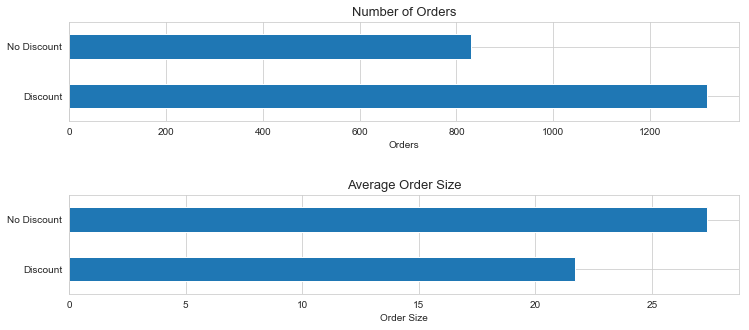

In [52]:
# Comparing the Number of Orders and Average Order Size to DisBool
fig, axes = plt.subplots(2, 1, figsize = (12, 5))
sns.set_style('whitegrid')

#Grouping DataFrame for visualization
df_discount_find.groupby(['DisBool'])['Quantity'].count().plot(kind = 'barh', ax = axes[0])
df_discount_find.groupby(['DisBool'])['Quantity'].mean().plot(kind = 'barh', ax = axes[1])
# First plot labels
axes[0].set_title('Number of Orders', fontsize = 13)
axes[0].set_xlabel('Orders')
axes[0].set_ylabel('')
axes[0].set_yticklabels(['Discount', 'No Discount'])
#Second plot labels
axes[1].set_title('Average Order Size', fontsize = 13)
axes[1].set_xlabel('Order Size')
axes[1].set_ylabel('')
axes[1].set_yticklabels(['Discount', 'No Discount'])
fig.subplots_adjust(hspace = .75)
plt.show()

As we can see above, the number of orders for discounted items is low but the average order size is large compared to non-discounted items. In order to determine the size of the effect, we will test whether this difference is statistically significant.

In [53]:
#Separating discounted items from non-discounted items
query1 = 'DisBool > 0'
df_discount_bool = df_discount_find.query(query1)
query2 ='DisBool == 0'
df_nodiscount_bool = df_discount_find.query(query2)

In [54]:
df_discount_bool.describe()

,ProductId,UnitPrice,Quantity,Discount,DisBool
count,830.000000,830.000000,830.000000,830.000000,830.0
mean,39.868675,26.255482,27.354217,0.145542,1.0
std,22.019037,30.091176,20.720667,0.071250,0.0
min,1.000000,2.000000,1.000000,0.050000,1.0
25%,21.000000,12.125000,12.250000,0.100000,1.0
50%,40.000000,18.000000,20.000000,0.150000,1.0
75%,59.000000,31.230000,36.000000,0.200000,1.0
max,77.000000,263.500000,130.000000,0.250000,1.0


In [55]:
df_nodiscount_bool.describe()

,ProductId,UnitPrice,Quantity,Discount,DisBool
count,1317.000000,1317.000000,1317.000000,1317.0,1317.0
mean,41.396355,26.171534,21.715262,0.0,0.0
std,22.217410,29.717354,17.507493,0.0,0.0
min,1.000000,2.000000,1.000000,0.0,0.0
25%,23.000000,12.000000,10.000000,0.0,0.0
50%,41.000000,18.400000,18.000000,0.0,0.0
75%,60.000000,32.800000,30.000000,0.0,0.0
max,77.000000,263.500000,130.000000,0.0,0.0


In [56]:
#Generate values to create a normal distribution
discount_mu, discount_sigma, n_discount = 27.35, 20.72, 830
nodiscount_mu, nodiscount_sigma, n_nodiscount = 21.72, 17.51, 1317
gen_discount = np.random.normal(discount_mu, discount_sigma, n_discount)
gen_nodiscount = np.random.normal(nodiscount_mu, nodiscount_sigma, n_nodiscount)

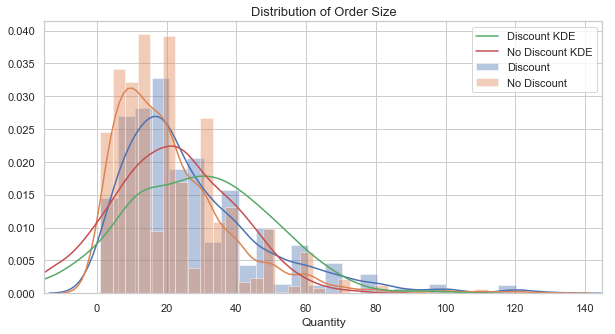

In [59]:
sns.set(rc={'figure.figsize':(10, 5)})
sns.set_style('whitegrid')

ax = sns.distplot(df_discount_bool.Quantity, label = 'Discount')
ax = sns.distplot(df_nodiscount_bool.Quantity, label = 'No Discount')
ax = sns.kdeplot(gen_discount, label = 'Discount KDE')
ax = sns.kdeplot(gen_nodiscount, label = 'No Discount KDE')
ax.set_xlim(-15, 145)
ax.set_title('Distribution of Order Size', fontsize = 13)
ax.legend()

The KDE plot shows us the while there is some postive skew present in the Order distribution size. However because of the sample size we can assume that the distribution is normal.
Because our variables are independent, distributed normally and don't show homogeneity in variance, we will use the Welch's t-test to test test our hypothesis.

In [60]:
a = df_discount_bool.Quantity.mean()
b = df_nodiscount_bool.Quantity.mean()
print(a, b)

27.35421686746988 21.715261958997722


In [83]:
#welch's t-test and Cohen's d
t_stat, p = stats.ttest_ind(df_discount_bool.Quantity, df_nodiscount_bool.Quantity) 
d = cohen_d(df_discount_bool.Quantity, df_nodiscount_bool.Quantity)
print(t_stat, p)
print("Reject Null Hypothesis") if p < 0.025 else print("Failed to reject the null hypothesis")
print("Cohen's d: ", d)

6.7627297036707565 1.7401995278127614e-11
Reject Null Hypothesis
Cohen's d:  0.2997078720940889


In [82]:
discounts_significance_df = pd.DataFrame(columns = ['Discount %', 'Null Hypothesis', "Cohen's d"], index = None)
discounts = [0.05, 0.10, 0.15, 0.20, 0.25]
for i in discounts:
    t_stat, p = stats.ttest_ind(df_discount_bool.Quantity, df_nodiscount_bool.Quantity) 
    d = cohen_d(df_discount_bool.Quantity, df_nodiscount_bool.Quantity)
    discounts_significance_df = discounts_significance_df.append({'Discount %': str(i*100), 'Null Hypothesis': 'Reject' 
                            if p < 0.025 else 'Failed', "Cohen's d": d }, ignore_index = True)

In [84]:
discounts_significance_df

,Discount %,Null Hypothesis,Cohen's d
0,5.0,Reject,0.299708
1,10.0,Reject,0.299708
2,15.0,Reject,0.299708
3,20.0,Reject,0.299708
4,25.0,Reject,0.299708


As we can see above, we have a p-value of 1.70 * 10^11 which is much smaller than 0.05 which means there is a statistical significance between number of orders between discounted and non discounted items. Therefore we can reject the null hypothesis.
Because there is a significance between discounted and non discounted items, we can investigate which discount level has the highest significance.

### 1b) At what discount level(s) is there a statistical significance?

$H_0$ : The average number of orders is the same regardless of discount level <br>
$H_a$ : The average number of orders is not the same the level of discount changes <br>
$alpha$ : 0.05

In [ ]:
#Viewing difference between discount levels against number of orders and average order size visually
fig, axes = plt.subplot(2,1, figsize = (12,5))